# 基于 PyTorch 的预训练模型在隐语联邦学习环境下的微调
## 引言
预训练模型加载和精调在机器学习中非常重要。一般来说，从头训练一个非常大的模型，不仅需要大量的算力资源，同时也需要耗费大量的时间。所以在传统的机器学习中，使用预训练模型，然后针对具体的任务做微调和迁移学习非常普遍。同样的，对于联邦学习来说，如果能够加载预训练模型进行微调和迁移学习，不仅能够节省参与方的算力资源，降低参与方的准入门槛，同时也能够加快模型的学习速度。

得益于隐语联邦学习模块优异的兼容性，使得其可以直接加载 PyTorch 的一系列[预训练模型](https://pytorch.org/vision/master/models.html)；本教程将基于 PyTorch 的 [AlexNet](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) 的微调教程展现如何基于PyTorch的[预训练模型](https://pytorch.org/vision/master/models/alexnet.html)在SecretFlow的框架下进行微调，充分展现SecretFlow的易用性。

In [1]:
%load_ext autoreload
%autoreload 2

## 加载数据集
### 数据集介绍
Flower 数据集介绍：flower 数据集是一个包含了 5 种花卉（雏菊、蒲公英、玫瑰、向日葵、郁金香）共计 4323 张彩色图片的数据集。每种花卉都有多个角度和不同光照下的图片，每张图片的分辨率为 320x240。这个数据集常用于图像分类和机器学习算法的训练与测试。数据集中每个类别的数量分别是：daisy（633），dandelion（898），rose（641），sunflower（699），tulip（852）

下载地址: http://download.tensorflow.org/example_images/flower_photos.tgz

### 下载数据集并解压

In [2]:
# The TensorFlow interface is reused to download images , and the output is a folder, as shown in the following figure.
import tempfile
import tensorflow as tf

_temp_dir = tempfile.mkdtemp()
path_to_flower_dataset = tf.keras.utils.get_file(
    "flower_photos",
    "https://secretflow-data.oss-accelerate.aliyuncs.com/datasets/tf_flowers/flower_photos.tgz",
    untar=True,
    cache_dir=_temp_dir,
)

2023-10-29 02:10:49.666627: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-29 02:10:50.522159: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-29 02:10:50.619157: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-29 02:10:50.619183: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

67588319/67588319 [==============================] - 3s 0us/step


## 环境设置
首先我们初始化各个参与方。

In [3]:
import secretflow as sf

# Check the version of your SecretFlow
print('The version of SecretFlow: {}'.format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()
sf.init(['alice', 'bob', 'charlie'], address="local", log_to_driver=False)
alice, bob, charlie = sf.PYU('alice'), sf.PYU('bob'), sf.PYU('charlie')

The version of SecretFlow: 1.2.0.dev20231009


2023-10-29 02:11:04,382	INFO worker.py:1538 -- Started a local Ray instance.


## 定义Dataloader
我们可以参考[PyTorch下的DataBuilder教程](https://www.secretflow.org.cn/docs/secretflow/latest/zh-Hans/tutorial/CustomDataLoaderTorch)定义我们自己的DataBuilder。

In [4]:
def create_dataset_builder(
    batch_size=32,
    train_split=0.8,
    shuffle=True,
    random_seed=1234,
):
    def dataset_builder(x, stage="train"):
        """ """
        import math

        import numpy as np
        from torch.utils.data import DataLoader
        from torch.utils.data.sampler import SubsetRandomSampler
        from torchvision import datasets, transforms

        # Define dataset
        flower_transform = transforms.Compose(
            [
                transforms.Resize((180, 180)),
                transforms.ToTensor(),
            ]
        )
        flower_dataset = datasets.ImageFolder(x, transform=flower_transform)
        dataset_size = len(flower_dataset)
        # Define sampler

        indices = list(range(dataset_size))
        if shuffle:
            np.random.seed(random_seed)
            np.random.shuffle(indices)
        split = int(np.floor(train_split * dataset_size))
        train_indices, val_indices = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(val_indices)

        # Define databuilder
        train_loader = DataLoader(
            flower_dataset, batch_size=batch_size, sampler=train_sampler
        )
        valid_loader = DataLoader(
            flower_dataset, batch_size=batch_size, sampler=valid_sampler
        )

        # Return
        if stage == "train":
            train_step_per_epoch = math.ceil(split / batch_size)

            return train_loader, train_step_per_epoch
        elif stage == "eval":
            eval_step_per_epoch = math.ceil((dataset_size - split) / batch_size)
            return valid_loader, eval_step_per_epoch

    return dataset_builder

In [5]:
# prepare dataset dict
data_builder_dict = {
    alice: create_dataset_builder(
        batch_size=32,
        train_split=0.8,
        shuffle=False,
        random_seed=1234,
    ),
    bob: create_dataset_builder(
        batch_size=32,
        train_split=0.8,
        shuffle=False,
        random_seed=1234,
    ),
}

## 加载模型
我们只要参照教程里对模型的定义，在函数里完成我们对模型的定义即可；可以看到代码几乎不需要作任何修改，只需要进行适当的封装。并且得益于隐语优异的封装性，我们可以在定义模型很快进行进行训练，而不是需要自行编写训练和测试函数；相反如果我们自行从头开始写整个神经网络结构的话，我们需要自行参考AlexNet的[源代码](https://pytorch.org/vision/master/_modules/torchvision/models/alexnet.html#alexnet)，将其适配在隐语的`secretflow_fl.ml.nn.core.torch.BaseModule`;为便于对比，我们分别给出两种实现方式：

### 加载预训练模型

In [6]:
from secretflow_fl.ml.nn.core.torch import BaseModule
from torchvision.models import alexnet
from torch import nn


class AlexNet(BaseModule):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.finetune_net = alexnet(weights='IMAGENET1K_V1')
        self.finetune_net.classifier[6] = nn.Linear(4096, 5)
        nn.init.xavier_uniform_(self.finetune_net.classifier[6].weight)

        for named_param in self.finetune_net.named_parameters():
            if 'classifier' in named_param[0]:
                print('Will train', named_param[0])
                named_param[1].requires_grad = True
            else:
                print('Won\'t train', named_param[0])
                named_param[1].requires_grad = False

    def forward(self, xb):
        return self.finetune_net(xb)

### 自行编写网络结构

In [7]:
import torch


class handy_AlexNet(BaseModule):
    def __init__(self, num_classes: int = 5, dropout: float = 0.5, **kwargs) -> None:
        super().__init__(**kwargs)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

        for named_param in self.features.named_parameters():
            named_param[1].requires_grad = True

        for named_param in self.classifier.named_parameters():
            named_param[1].requires_grad = True

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [8]:
from secretflow_fl.ml.nn import FLModel
from secretflow.security.aggregation import SecureAggregator
from torch import nn, optim
from torchmetrics import Accuracy, Precision
from secretflow_fl.ml.nn.core.torch import metric_wrapper, optim_wrapper, TorchModel

## 定义 FLModel 并且训练

### 基于预训练模型定义 Torch 后端的 FLModel 

In [9]:
device_list = [alice, bob]
aggregator = SecureAggregator(charlie, [alice, bob])

data = {
    alice: path_to_flower_dataset,
    bob: path_to_flower_dataset,
}
# prepare model
num_classes = 5


# torch model
loss_fn = nn.CrossEntropyLoss
optim_fn = optim_wrapper(optim.Adam, lr=1e-3)
model_def = TorchModel(
    model_fn=AlexNet,
    loss_fn=loss_fn,
    optim_fn=optim_fn,
    metrics=[
        metric_wrapper(
            Accuracy, task="multiclass", num_classes=num_classes, average='micro'
        ),
        metric_wrapper(
            Precision, task="multiclass", num_classes=num_classes, average='micro'
        ),
    ],
)

fed_model = FLModel(
    device_list=device_list,
    model=model_def,
    aggregator=aggregator,
    backend="torch",
    strategy="fed_avg_w",
    random_seed=1234,
)

INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party bob.
INFO:root:Create proxy actor <class 'secretflow_fl.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party alice.
INFO:root:Create proxy actor <class 'secretflow_fl.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party bob.


### 基于预训练模型的 FLModel 开始训练

In [10]:
history = fed_model.fit(
    data,
    None,
    validation_data=data,
    epochs=20,
    batch_size=32,
    aggregate_freq=2,
    sampler_method="batch",
    random_seed=1234,
    dp_spent_step_freq=1,
    dataset_builder=data_builder_dict,
)

INFO:root:FL Train Params: {'x': {PYURuntime(alice): '/tmp/tmphh_f8sq7/datasets/flower_photos', PYURuntime(bob): '/tmp/tmphh_f8sq7/datasets/flower_photos'}, 'y': None, 'batch_size': 32, 'batch_sampling_rate': None, 'epochs': 20, 'verbose': 1, 'callbacks': None, 'validation_data': {PYURuntime(alice): '/tmp/tmphh_f8sq7/datasets/flower_photos', PYURuntime(bob): '/tmp/tmphh_f8sq7/datasets/flower_photos'}, 'shuffle': False, 'class_weight': None, 'sample_weight': None, 'validation_freq': 1, 'aggregate_freq': 2, 'label_decoder': None, 'max_batch_size': 20000, 'prefetch_buffer_size': None, 'sampler_method': 'batch', 'random_seed': 1234, 'dp_spent_step_freq': 1, 'audit_log_dir': None, 'dataset_builder': {PYURuntime(alice): <function create_dataset_builder.<locals>.dataset_builder at 0x7f683654edc0>, PYURuntime(bob): <function create_dataset_builder.<locals>.dataset_builder at 0x7f68365845e0>}, 'wait_steps': 100, 'self': <secretflow_fl.ml.nn.fl.fl_model.FLModel object at 0x7f689e8d44c0>}
100%|██

### 训练结果可视化

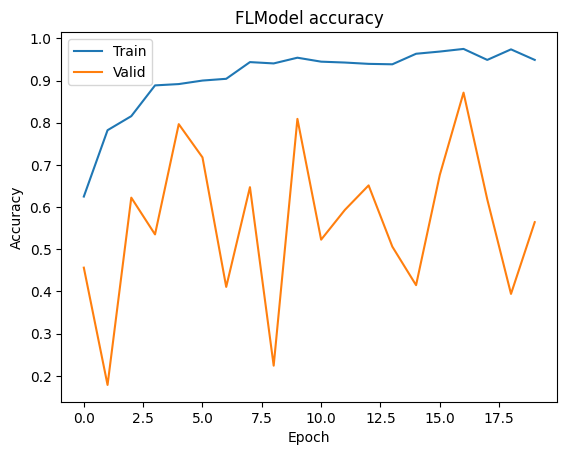

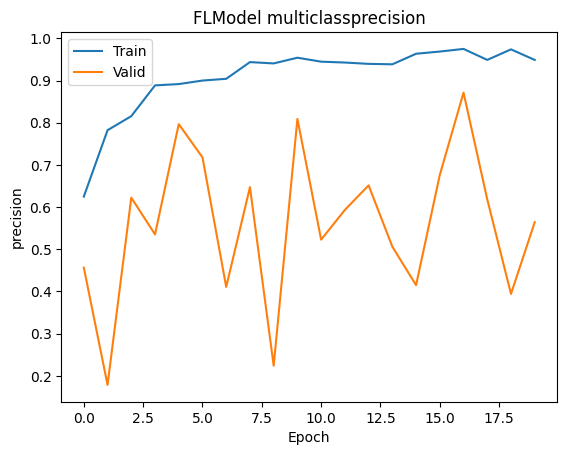

In [11]:
from matplotlib import pyplot as plt

# Draw accuracy values for training & validation
plt.plot(history.global_history['multiclassaccuracy'])
plt.plot(history.global_history['val_multiclassaccuracy'])
plt.title('FLModel accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Draw precision for training & validation
plt.plot(history.global_history['multiclassprecision'])
plt.plot(history.global_history['val_multiclassprecision'])
plt.title('FLModel multiclassprecision')
plt.ylabel('precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

### 基于自编写网络定义 Torch 后端的 FLModel 

In [12]:
model_def = TorchModel(
    model_fn=handy_AlexNet,
    loss_fn=loss_fn,
    optim_fn=optim_fn,
    metrics=[
        metric_wrapper(
            Accuracy, task="multiclass", num_classes=num_classes, average='micro'
        ),
        metric_wrapper(
            Precision, task="multiclass", num_classes=num_classes, average='micro'
        ),
    ],
)

fed_model = FLModel(
    device_list=device_list,
    model=model_def,
    aggregator=aggregator,
    backend="torch",
    strategy="fed_avg_w",
    random_seed=1234,
)

INFO:root:Create proxy actor <class 'secretflow_fl.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party alice.
INFO:root:Create proxy actor <class 'secretflow_fl.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party bob.


### 基于自编写网络模型的 FLModel 开始训练

In [13]:
history = fed_model.fit(
    data,
    None,
    validation_data=data,
    epochs=20,
    batch_size=32,
    aggregate_freq=2,
    sampler_method="batch",
    random_seed=1234,
    dp_spent_step_freq=1,
    dataset_builder=data_builder_dict,
)

INFO:root:FL Train Params: {'x': {PYURuntime(alice): '/tmp/tmphh_f8sq7/datasets/flower_photos', PYURuntime(bob): '/tmp/tmphh_f8sq7/datasets/flower_photos'}, 'y': None, 'batch_size': 32, 'batch_sampling_rate': None, 'epochs': 20, 'verbose': 1, 'callbacks': None, 'validation_data': {PYURuntime(alice): '/tmp/tmphh_f8sq7/datasets/flower_photos', PYURuntime(bob): '/tmp/tmphh_f8sq7/datasets/flower_photos'}, 'shuffle': False, 'class_weight': None, 'sample_weight': None, 'validation_freq': 1, 'aggregate_freq': 2, 'label_decoder': None, 'max_batch_size': 20000, 'prefetch_buffer_size': None, 'sampler_method': 'batch', 'random_seed': 1234, 'dp_spent_step_freq': 1, 'audit_log_dir': None, 'dataset_builder': {PYURuntime(alice): <function create_dataset_builder.<locals>.dataset_builder at 0x7f683654edc0>, PYURuntime(bob): <function create_dataset_builder.<locals>.dataset_builder at 0x7f68365845e0>}, 'wait_steps': 100, 'self': <secretflow_fl.ml.nn.fl.fl_model.FLModel object at 0x7f689e53fac0>}
100%|██

### 训练结果可视化

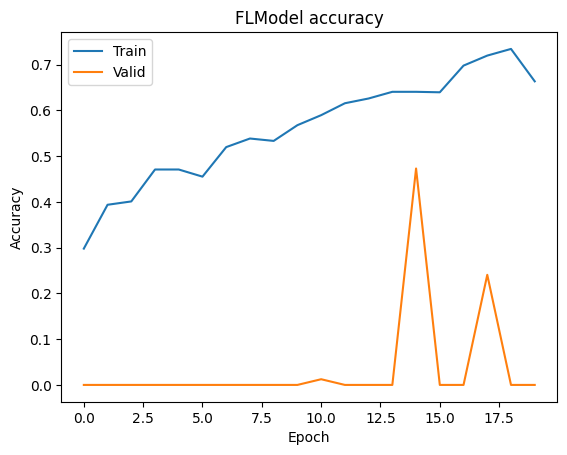

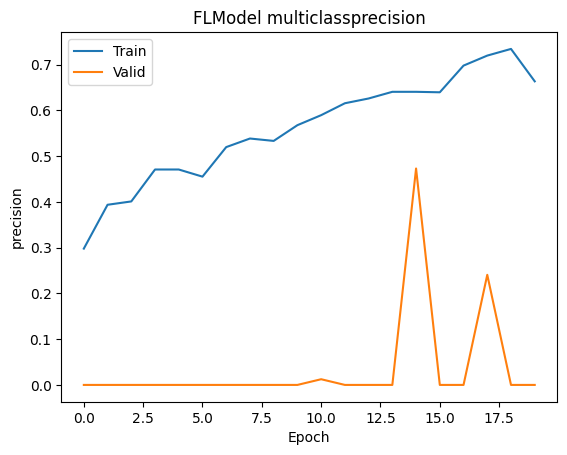

In [14]:
# Draw accuracy values for training & validation
plt.plot(history.global_history['multiclassaccuracy'])
plt.plot(history.global_history['val_multiclassaccuracy'])
plt.title('FLModel accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Draw precision for training & validation
plt.plot(history.global_history['multiclassprecision'])
plt.plot(history.global_history['val_multiclassprecision'])
plt.title('FLModel multiclassprecision')
plt.ylabel('precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

可以看到，在同样的任务，同样的模型上，我们加载预训练模型，不仅能省时省力，还能获得更好的模型性能。

## 小结
隐语能够无缝地兼容基于 PyTorch 预训练模型，我们可以不需要自己再重新写出复杂网络的模型结构，这对于大型网络结构可以起到省时省力的效果。并且通过加载预训练模型的权重，可以让我们的模型性能更优秀。

本篇教程，我们以 AlexNet 为例介绍了如何在隐语的联邦学习模式下基于直接加载 PyTorch 的[预训练模型](https://pytorch.org/vision/stable/models.html)，通过直接加载预训练模型，我们能够获得：
- 不需要再次编写复杂模型的结构代码
- 基于预训练模型进行微调和迁移学习
- 使用预训练权重模型能够使得联邦模型获得更好的性能